In [10]:
###################################
##### Supervised learning to predict a dichotomized outcome
##### Evaluate and compare a battery of 8 supervised learning algorithms
##### Originated by Matthew Ye, July 2020
##### QC and streamlined by Chelsea Jue Jin, Aug 27, 2020
###################################

#import libraries

import numpy as np
import pandas as pd
import csv
import re
from random import random
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from joblib import dump, load
from mpl_toolkits.mplot3d import Axes3D

In [11]:
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, log_loss, confusion_matrix, make_scorer
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.linear_model import Lasso, LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
#from sklearn.ensemble import partial_dependence
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.inspection import partial_dependence

import warnings
warnings.filterwarnings('ignore')

In [3]:
### import, explore and manipulate the data 

# the data that were used for supervised learning model with mortality_rate as a continuous outcome 
data_old = pd.read_csv('../data/a.csv')
data_old = data_old[(data_old.state!="GU") & (data_old.state!="PR")]
print(data_old.shape)
data_old.drop(columns=['country_region','last_update', 'lat', 'long', 'confirmed', 'deaths','recovered', 'active', 
                  'people_tested', 'people_hospitalized', 'testing_rate', 'incident_rate', 'hospitalization_rate'], 
              inplace=True)
print(data_old.shape)
print(data_old.head())

(51, 258)
(51, 245)
  state Locationdesc  mortality_rate  CLASS01_TOPIC03_DRNKANY5_RESP046_BO1  \
0    KY     Kentucky        5.599604                                 40.92   
1    OH         Ohio        3.831012                                 51.69   
2    WI    Wisconsin        4.310087                                 62.76   
3    OR       Oregon        3.405370                                 59.31   
4    MO     Missouri        2.762172                                 53.06   

   CLASS01_TOPIC03_DRNKANY5_RESP054_BO1  CLASS01_TOPIC07__RFBING5_RESP046_BO1  \
0                                 59.08                                 14.70   
1                                 48.31                                 15.81   
2                                 37.24                                 23.79   
3                                 40.69                                 15.86   
4                                 46.94                                 17.63   

   CLASS01_TOPIC07__RFBI

In [4]:
# the data that contain mortality_rate by state on Aug 27, 2020
data_new = pd.read_csv('../data/b_Aug272020.csv')
print(data_new.shape)
print(data_new.head())

(574, 18)
                 province_state country_region    last_update      lat  \
0  Australian Capital Territory      Australia  8/27/20 12:30 -35.4735   
1               New South Wales      Australia  8/27/20 12:30 -33.8688   
2            Northern Territory      Australia  8/27/20 12:30 -12.4634   
3                    Queensland      Australia  8/27/20 12:30 -27.4698   
4               South Australia      Australia  8/27/20 12:30 -34.9285   

       long  confirmed  deaths  recovered  active  fips  incident_rate  \
0  149.0124        113       3      110.0       0   NaN      26.395702   
1  151.2093       4006      52     2994.0     960   NaN      49.347130   
2  130.8456         33       0       31.0       2   NaN      13.436482   
3  153.0251       1110       6     1083.0      21   NaN      21.698759   
4  138.6007        463       4      456.0       3   NaN      26.359237   

   people_tested  people_hospitalized  mortality_rate   uid iso3  \
0            NaN                

In [5]:
data_new_2 = data_new.loc[data_new.country_region == "US",["province_state","mortality_rate"]]
data_new_2 = data_new_2.rename(columns = {"province_state":"Locationdesc","mortality_rate": "mortality_rate_2"})
print(data_new_2.shape)
print(data_new_2.head())

(58, 2)
       Locationdesc  mortality_rate_2
474         Alabama          1.714827
475          Alaska          0.755873
476  American Samoa               NaN
477         Arizona          2.454640
478        Arkansas          1.261569


In [6]:
# merge the new data with the old one

data = pd.merge(data_new_2, data_old, on = "Locationdesc", how = "right")
print(data.shape)
print(data.head())

(51, 246)
  Locationdesc  mortality_rate_2 state  mortality_rate  \
0      Alabama          1.714827    AL        2.630850   
1       Alaska          0.755873    AK        2.941176   
2      Arizona          2.454640    AZ        3.246753   
3     Arkansas          1.261569    AR        2.109375   
4   California          1.825135    CA        2.925657   

   CLASS01_TOPIC03_DRNKANY5_RESP046_BO1  CLASS01_TOPIC03_DRNKANY5_RESP054_BO1  \
0                                 42.91                                 57.09   
1                                 54.59                                 45.41   
2                                 51.91                                 48.09   
3                                 44.71                                 55.29   
4                                 53.83                                 46.17   

   CLASS01_TOPIC07__RFBING5_RESP046_BO1  CLASS01_TOPIC07__RFBING5_RESP054_BO1  \
0                                 12.58                                 8

In [7]:
data.mortality_rate_2.describe()

count    51.000000
mean      2.867864
std       1.984502
min       0.702479
25%       1.483322
50%       2.038067
75%       3.539780
max       8.546534
Name: mortality_rate_2, dtype: float64

In [8]:
# calculate the difference in mortality_rate between April 13 and Aug 27, 2020

data['mortality_diff'] = data.mortality_rate_2 - data.mortality_rate
data.mortality_diff.describe()

count    51.000000
mean     -0.146534
std       1.869164
min      -3.605352
25%      -1.008273
50%      -0.495023
75%       0.622341
max       4.562807
Name: mortality_diff, dtype: float64

In [9]:
# create a binary variable by mortality_rate increase (>= 0) and decrease (<0)

data['mortality_diffcat'] = data.mortality_diff.apply(lambda x : 1 if x >= 0 else 0)
np.unique(data.mortality_diffcat, return_counts = True)

(array([0, 1], dtype=int64), array([33, 18], dtype=int64))

In [10]:
print(data.shape)
data.head()

(51, 248)


,Locationdesc,mortality_rate_2,state,mortality_rate,CLASS01_TOPIC03_DRNKANY5_RESP046_BO1,CLASS01_TOPIC03_DRNKANY5_RESP054_BO1,CLASS01_TOPIC07__RFBING5_RESP046_BO1,CLASS01_TOPIC07__RFBING5_RESP054_BO1,CLASS01_TOPIC30__RFDRHV6_RESP205_BO1,CLASS01_TOPIC30__RFDRHV6_RESP206_BO1,...,percent_native_hawaiian_other_pacific_islander,percent_hispanic,percent_non_hispanic_white,percent_not_proficient_in_english,percent_female,percent_rural,hospital_bed_occupancy_rate,icu_bed_occupancy_rate,mortality_diff,mortality_diffcat
0,Alabama,1.714827,AL,2.630850,42.91,57.09,12.58,87.42,94.55,5.45,...,0.106529,4.443264,65.413428,1.061048,51.633032,40.963183,0.64,0.68,-0.916023,0
1,Alaska,0.755873,AK,2.941176,54.59,45.41,15.89,84.11,92.67,7.33,...,1.386015,7.226099,60.264185,1.712905,47.850124,33.980212,0.66,0.58,-2.185303,0
2,Arizona,2.454640,AZ,3.246753,51.91,48.09,15.63,84.37,94.43,5.57,...,0.275934,31.601434,54.420798,4.861131,50.285625,10.190179,0.62,0.53,-0.792113,0
3,Arkansas,1.261569,AR,2.109375,44.71,55.29,14.73,85.27,94.68,5.32,...,0.361036,7.737244,72.220882,1.592402,50.888223,43.839676,0.52,0.58,-0.847806,0
4,California,1.825135,CA,2.925657,53.83,46.17,16.05,83.95,94.05,5.95,...,0.505275,39.285397,36.829364,9.810830,50.290582,5.047383,0.67,0.58,-1.100523,0


In [11]:
# create the outcome measurement - mortality rate of Aug 17 increased vs. decreased from Apr 13, 2020

y = data['mortality_diffcat'] # Labels
print(len(y))
states = data['state'] # If we want to look a state up later
print(len(states))

51
51


In [12]:
# drop a few features and leave 242 predictors

X = data.drop(['Locationdesc','state','mortality_rate_2','mortality_rate','mortality_diff','mortality_diffcat'],axis=1)
print(X.shape)
X.describe()

(51, 242)


,CLASS01_TOPIC03_DRNKANY5_RESP046_BO1,CLASS01_TOPIC03_DRNKANY5_RESP054_BO1,CLASS01_TOPIC07__RFBING5_RESP046_BO1,CLASS01_TOPIC07__RFBING5_RESP054_BO1,CLASS01_TOPIC30__RFDRHV6_RESP205_BO1,CLASS01_TOPIC30__RFDRHV6_RESP206_BO1,CLASS03_TOPIC05__DRDXAR1_RESP046_BO1,CLASS03_TOPIC05__DRDXAR1_RESP054_BO1,CLASS03_TOPIC06__CASTHM1_RESP046_BO1,CLASS03_TOPIC06__CASTHM1_RESP054_BO1,...,percent_american_indian_alaska_native,percent_asian,percent_native_hawaiian_other_pacific_islander,percent_hispanic,percent_non_hispanic_white,percent_not_proficient_in_english,percent_female,percent_rural,hospital_bed_occupancy_rate,icu_bed_occupancy_rate
count,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,...,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000
mean,53.120196,46.879804,16.672353,83.327647,93.488431,6.511569,27.065294,72.934706,9.670000,90.330000,...,1.994106,4.530516,0.396324,12.115673,67.898564,2.727537,50.595734,25.900309,0.630588,0.611765
std,7.560503,7.560503,2.943451,2.943451,1.164332,1.164332,4.073355,4.073355,1.221208,1.221208,...,3.075071,5.512084,1.424121,10.328175,16.170480,2.088609,0.832818,14.885564,0.066012,0.075517
min,29.700000,33.290000,10.620000,75.570000,91.230000,3.750000,18.750000,59.860000,7.410000,87.730000,...,0.250632,0.849359,0.029239,1.672415,21.756069,0.308494,47.850124,0.000000,0.510000,0.360000
25%,49.430000,41.290000,14.720000,82.195000,92.640000,5.835000,24.835000,70.865000,8.800000,89.845000,...,0.536620,1.793183,0.076953,5.212181,57.512968,1.238564,50.187951,12.465325,0.580000,0.580000
50%,53.830000,46.170000,16.160000,83.840000,93.550000,6.450000,26.280000,73.720000,9.450000,90.550000,...,0.735290,3.029929,0.112072,9.637290,71.400704,2.058101,50.681976,25.801842,0.630000,0.610000
75%,58.710000,50.570000,17.805000,85.280000,94.165000,7.360000,29.135000,75.165000,10.155000,91.200000,...,1.622879,5.007338,0.177190,13.759653,79.385779,3.736033,51.193516,34.611099,0.680000,0.650000
max,66.710000,70.300000,24.430000,89.380000,96.250000,8.770000,40.140000,81.250000,12.270000,92.590000,...,15.393294,37.638464,10.194081,49.118032,93.147435,9.810830,52.551124,61.340178,0.780000,0.780000


In [13]:
# use means to impute the missing values of the features with missing records

X.fillna(X.mean(), inplace=True)
X.describe()

,CLASS01_TOPIC03_DRNKANY5_RESP046_BO1,CLASS01_TOPIC03_DRNKANY5_RESP054_BO1,CLASS01_TOPIC07__RFBING5_RESP046_BO1,CLASS01_TOPIC07__RFBING5_RESP054_BO1,CLASS01_TOPIC30__RFDRHV6_RESP205_BO1,CLASS01_TOPIC30__RFDRHV6_RESP206_BO1,CLASS03_TOPIC05__DRDXAR1_RESP046_BO1,CLASS03_TOPIC05__DRDXAR1_RESP054_BO1,CLASS03_TOPIC06__CASTHM1_RESP046_BO1,CLASS03_TOPIC06__CASTHM1_RESP054_BO1,...,percent_american_indian_alaska_native,percent_asian,percent_native_hawaiian_other_pacific_islander,percent_hispanic,percent_non_hispanic_white,percent_not_proficient_in_english,percent_female,percent_rural,hospital_bed_occupancy_rate,icu_bed_occupancy_rate
count,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,...,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000
mean,53.120196,46.879804,16.672353,83.327647,93.488431,6.511569,27.065294,72.934706,9.670000,90.330000,...,1.994106,4.530516,0.396324,12.115673,67.898564,2.727537,50.595734,25.900309,0.630588,0.611765
std,7.560503,7.560503,2.943451,2.943451,1.164332,1.164332,4.073355,4.073355,1.221208,1.221208,...,3.075071,5.512084,1.424121,10.328175,16.170480,2.088609,0.832818,14.885564,0.066012,0.075517
min,29.700000,33.290000,10.620000,75.570000,91.230000,3.750000,18.750000,59.860000,7.410000,87.730000,...,0.250632,0.849359,0.029239,1.672415,21.756069,0.308494,47.850124,0.000000,0.510000,0.360000
25%,49.430000,41.290000,14.720000,82.195000,92.640000,5.835000,24.835000,70.865000,8.800000,89.845000,...,0.536620,1.793183,0.076953,5.212181,57.512968,1.238564,50.187951,12.465325,0.580000,0.580000
50%,53.830000,46.170000,16.160000,83.840000,93.550000,6.450000,26.280000,73.720000,9.450000,90.550000,...,0.735290,3.029929,0.112072,9.637290,71.400704,2.058101,50.681976,25.801842,0.630000,0.610000
75%,58.710000,50.570000,17.805000,85.280000,94.165000,7.360000,29.135000,75.165000,10.155000,91.200000,...,1.622879,5.007338,0.177190,13.759653,79.385779,3.736033,51.193516,34.611099,0.680000,0.650000
max,66.710000,70.300000,24.430000,89.380000,96.250000,8.770000,40.140000,81.250000,12.270000,92.590000,...,15.393294,37.638464,10.194081,49.118032,93.147435,9.810830,52.551124,61.340178,0.780000,0.780000


In [14]:
# standardize all features and compute z-scores - this step can only be useful for Lasso and Ridge regressions

scaled = StandardScaler().fit_transform(X)
print(scaled.shape)
Xscaled = pd.DataFrame(scaled, columns=X.columns)
print(Xscaled.shape)
Xscaled.describe()

(51, 242)
(51, 242)


,CLASS01_TOPIC03_DRNKANY5_RESP046_BO1,CLASS01_TOPIC03_DRNKANY5_RESP054_BO1,CLASS01_TOPIC07__RFBING5_RESP046_BO1,CLASS01_TOPIC07__RFBING5_RESP054_BO1,CLASS01_TOPIC30__RFDRHV6_RESP205_BO1,CLASS01_TOPIC30__RFDRHV6_RESP206_BO1,CLASS03_TOPIC05__DRDXAR1_RESP046_BO1,CLASS03_TOPIC05__DRDXAR1_RESP054_BO1,CLASS03_TOPIC06__CASTHM1_RESP046_BO1,CLASS03_TOPIC06__CASTHM1_RESP054_BO1,...,percent_american_indian_alaska_native,percent_asian,percent_native_hawaiian_other_pacific_islander,percent_hispanic,percent_non_hispanic_white,percent_not_proficient_in_english,percent_female,percent_rural,hospital_bed_occupancy_rate,icu_bed_occupancy_rate
count,5.100000e+01,5.100000e+01,5.100000e+01,5.100000e+01,5.100000e+01,5.100000e+01,5.100000e+01,5.100000e+01,5.100000e+01,5.100000e+01,...,5.100000e+01,5.100000e+01,5.100000e+01,5.100000e+01,5.100000e+01,5.100000e+01,5.100000e+01,5.100000e+01,5.100000e+01,5.100000e+01
mean,-6.132928e-16,5.654178e-16,1.921121e-16,-9.143013e-17,-8.719605e-15,6.585146e-16,-1.074304e-15,-5.115734e-16,2.394599e-17,-1.036208e-14,...,-1.708873e-16,-4.571507e-17,3.210939e-17,1.148319e-16,-2.394599e-17,-8.707632e-17,7.915237e-15,3.831358e-16,-4.310278e-16,8.881784e-16
std,1.009950e+00,1.009950e+00,1.009950e+00,1.009950e+00,1.009950e+00,1.009950e+00,1.009950e+00,1.009950e+00,1.009950e+00,1.009950e+00,...,1.009950e+00,1.009950e+00,1.009950e+00,1.009950e+00,1.009950e+00,1.009950e+00,1.009950e+00,1.009950e+00,1.009950e+00,1.009950e+00
min,-3.128527e+00,-1.815359e+00,-2.076670e+00,-2.661787e+00,-1.958980e+00,-2.395405e+00,-2.061700e+00,-3.241752e+00,-1.869042e+00,-2.150225e+00,...,-5.726118e-01,-6.744793e-01,-2.603276e-01,-1.021204e+00,-2.881896e+00,-1.169732e+00,-3.329575e+00,-1.757275e+00,-1.844926e+00,-3.367053e+00
25%,-4.929454e-01,-7.466997e-01,-6.698870e-01,-3.886313e-01,-7.359357e-01,-5.868607e-01,-5.529807e-01,-5.131643e-01,-7.194984e-01,-4.010997e-01,...,-4.786846e-01,-5.015474e-01,-2.264896e-01,-6.750646e-01,-6.486473e-01,-7.199952e-01,-4.945148e-01,-9.115321e-01,-7.739690e-01,-4.248151e-01
50%,9.481734e-02,-9.481734e-02,-1.757974e-01,1.757974e-01,5.340509e-02,-5.340509e-02,-1.947064e-01,1.947064e-01,-1.819421e-01,1.819421e-01,...,-4.134349e-01,-2.749448e-01,-2.015839e-01,-2.423510e-01,2.187312e-01,-3.237068e-01,1.045850e-01,-6.680717e-03,-8.999640e-03,-2.360084e-02
75%,7.466997e-01,4.929454e-01,3.886313e-01,6.698870e-01,5.868607e-01,7.359357e-01,5.131643e-01,5.529807e-01,4.010997e-01,7.194984e-01,...,-1.219227e-01,8.736547e-02,-1.554041e-01,1.607582e-01,7.174504e-01,4.876604e-01,7.249252e-01,5.910067e-01,7.559698e-01,5.113515e-01
max,1.815359e+00,3.128527e+00,2.661787e+00,2.076670e+00,2.395405e+00,1.958980e+00,3.241752e+00,2.061700e+00,2.150225e+00,1.869042e+00,...,4.400717e+00,6.066197e+00,6.948322e+00,3.618311e+00,1.576954e+00,3.425139e+00,2.371284e+00,2.404512e+00,2.285909e+00,2.249947e+00


In [15]:
roc_plots = {'train' : {}, 'test' : {}, 'best' : {}, 'best_roc':{}}

In [36]:
### define functions for evaluating each of 8 types of supervised learning algorithms to predict a binary outcome


def evaluate_model(seed, predictors, model, model_name, param_dict, passes=200):
    # seed = int(round(random()*1000,0))
    # print(seed)
    
    global roc_plots
    
    roc_plots['train'][model_name] = []
    roc_plots['test'][model_name] = []
    roc_plots['best'][model_name] = []
    roc_plots['best_roc'][model_name] = []
    
    # specify minimum test error (by log loss), best hyperparameter set
    test_err = []
    min_test_err = 1e10
    best_hyperparams = {}
    
    # specify error (by log loss) obtained from the full dataset
    full_err = []
    full_err_mintesterr = None
    
    # specify parameters related to ROC plots
    confm_mintesterr = None
    sensitivity = []
    sens_mintesterr = None
    specificity = []
    spec_mintesterr = None
    roc_auc = []
    rocauc_mintesterr = None
    youden = []
    youden_mintesterr = None
    
    # specify the final model returned
    best_model = None
    
    # define log loss as the statistic to determine goodness-of-fit - the smaller the better
    LogLoss = make_scorer(log_loss, greater_is_better=False, needs_proba=True)

    # split the data to a training-testing pair randomly by passes = n times
    for i in range(passes):
        print('Pass {}/{} for model {}'.format(i + 1, passes, model))
        X_train, X_test, y_train, y_test = train_test_split(predictors, y, test_size=0.3, stratify=y, random_state=(i+1)*seed)
        
        # 3-fold CV on a training set, and returns an optimal_model with the best_params_ fit
        default_model = model()
        model_gs = GridSearchCV(default_model, param_dict, cv=3, verbose=0, n_jobs=4, scoring=LogLoss)
        model_gs.fit(X_train, y_train)
        optimal_model = model(**model_gs.best_params_)
        optimal_model.fit(X_train, y_train)
        
        ## with the training set:
        # to generate ROC plot parameters
        y_pred_train = optimal_model.predict_proba(X_train)[:,1]
        
        fpr_tr, tpr_tr, _ = roc_curve(y_train, y_pred_train, pos_label = 1)
        roc_plots['train'][model_name] += [[fpr_tr, tpr_tr]]
        
        ## with the test set:
        # use the optimal_model generated above to test in the testing set and yield a log loss
        y_pred_test = optimal_model.predict_proba(X_test)[:,1]
        err = log_loss(y_test,y_pred_test)
        test_err.extend([err]) 
        
        # to generate ROC plot parameters
        fpr_ts, tpr_ts, _ = roc_curve(y_test, y_pred_test, pos_label = 1) 
        roc_plots['test'][model_name] += [[fpr_ts, tpr_ts]]

        ## with the full set:
        # use the optimal_model generated above to be applied to the full data set and predict y to yield an MSE
        y_predprob_tot = optimal_model.predict_proba(predictors)[:,1]
        tot_err = log_loss(y,y_predprob_tot)
        full_err.extend([tot_err]) 
        
        # generate confusion matrix and associated parameters, ROC
        y_pred_tot = optimal_model.predict(predictors)
        cm = confusion_matrix(y, y_pred_tot)
        tn, fp, fn, tp = cm.ravel()
        
        sens = tp/(tp+fn)
        sensitivity.extend([sens])
        spec = tn/(tn+fp)
        specificity.extend([spec])
        rocauc = roc_auc_score(y, y_predprob_tot)
        roc_auc.extend([rocauc])
        youdenidx = sens + spec - 1
        youden.extend([youdenidx])
        
        ## find the set of parameters associated with the smallest test log loss
        if err < min_test_err:
            best_hyperparams = model_gs.best_params_
            min_test_err = err
            full_err_mintesterr = tot_err
            confm_mintesterr = cm
            sens_mintesterr = sens
            spec_mintesterr = spec
            rocauc_mintesterr = rocauc
            youden_mintesterr = youdenidx
            
            fpr_b = None
            tpr_b = None
            fpr_b, tpr_b, _ = roc_curve(y, y_predprob_tot, pos_label = 1)
           # print(fpr_b)
           # print(tpr_b)
            roc_plots['best'][model_name] = [fpr_b, tpr_b]
            roc_plots['best_roc'][model_name] = rocauc_mintesterr

            best_model = optimal_model
    
    # examine distributions
    test_err_dist = pd.DataFrame(test_err, columns=["test_err"]).describe()
    full_err_dist = pd.DataFrame(full_err, columns=["full_err"]).describe()
    sensitivity_dist = pd.DataFrame(sensitivity, columns=["sensitivity"]).describe()
    specificity_dist = pd.DataFrame(specificity, columns=["specificity"]).describe()
    roc_auc_dist = pd.DataFrame(roc_auc, columns=["auc"]).describe()
    youden_dist = pd.DataFrame(youden, columns=["youden_index"]).describe()
    
    print(f'Model {model} with\nhyperparams {best_hyperparams} yielded \n\
log loss {min_test_err} with distribution \n{test_err_dist} \n\
total log loss {full_err_mintesterr} with distribution \n{full_err_dist} \n\
sensitivity {sens_mintesterr} with distribution \n{sensitivity_dist} \n\
specificity {spec_mintesterr} with distribution \n{specificity_dist} \n\
ROC AUC {rocauc_mintesterr} with distribution \n{roc_auc_dist} \n\
Youden {youden_mintesterr} with distribution \n{youden_dist} \n\
Confusion matrix:\n{confm_mintesterr}')
    
    return optimal_model

In [39]:
# LASSO

lasso = evaluate_model(561, Xscaled, LogisticRegression, 'Lasso', 
                       {'penalty': ['l1'],
                        'solver': ['liblinear'],
                        'tol': [1e-4, 1e-5, 1e-6],
                        'C' : [0.5, 1, 5, 10]}, passes=250)

Pass 1/250 for model <class 'sklearn.linear_model._logistic.LogisticRegression'>
Pass 2/250 for model <class 'sklearn.linear_model._logistic.LogisticRegression'>
Pass 3/250 for model <class 'sklearn.linear_model._logistic.LogisticRegression'>
Pass 4/250 for model <class 'sklearn.linear_model._logistic.LogisticRegression'>
Pass 5/250 for model <class 'sklearn.linear_model._logistic.LogisticRegression'>
Pass 6/250 for model <class 'sklearn.linear_model._logistic.LogisticRegression'>
Pass 7/250 for model <class 'sklearn.linear_model._logistic.LogisticRegression'>
Pass 8/250 for model <class 'sklearn.linear_model._logistic.LogisticRegression'>
Pass 9/250 for model <class 'sklearn.linear_model._logistic.LogisticRegression'>
Pass 10/250 for model <class 'sklearn.linear_model._logistic.LogisticRegression'>
Pass 11/250 for model <class 'sklearn.linear_model._logistic.LogisticRegression'>
Pass 12/250 for model <class 'sklearn.linear_model._logistic.LogisticRegression'>
Pass 13/250 for model <cl

In [19]:
# Ridge   

ridge = evaluate_model(846, Xscaled, LogisticRegression, 'Ridge', 
                       {'penalty': ['l2'],
                        'tol': [1e-4, 1e-5, 1e-6],
                        'C' : [0.5, 1, 5, 10]}, passes = 250)

Pass 1/250 for model <class 'sklearn.linear_model._logistic.LogisticRegression'>
Pass 2/250 for model <class 'sklearn.linear_model._logistic.LogisticRegression'>
Pass 3/250 for model <class 'sklearn.linear_model._logistic.LogisticRegression'>
Pass 4/250 for model <class 'sklearn.linear_model._logistic.LogisticRegression'>
Pass 5/250 for model <class 'sklearn.linear_model._logistic.LogisticRegression'>
Pass 6/250 for model <class 'sklearn.linear_model._logistic.LogisticRegression'>
Pass 7/250 for model <class 'sklearn.linear_model._logistic.LogisticRegression'>
Pass 8/250 for model <class 'sklearn.linear_model._logistic.LogisticRegression'>
Pass 9/250 for model <class 'sklearn.linear_model._logistic.LogisticRegression'>
Pass 10/250 for model <class 'sklearn.linear_model._logistic.LogisticRegression'>
Pass 11/250 for model <class 'sklearn.linear_model._logistic.LogisticRegression'>
Pass 12/250 for model <class 'sklearn.linear_model._logistic.LogisticRegression'>
Pass 13/250 for model <cl

In [20]:
# K-nearest neighborhood

knn = evaluate_model(451, X, KNeighborsClassifier, 'KNN', 
                     {'n_neighbors' : np.arange(1, 7),
                     'algorithm': ['ball_tree','kd_tree','brute']}, passes=250)

Pass 1/250 for model <class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Pass 2/250 for model <class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Pass 3/250 for model <class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Pass 4/250 for model <class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Pass 5/250 for model <class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Pass 6/250 for model <class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Pass 7/250 for model <class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Pass 8/250 for model <class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Pass 9/250 for model <class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Pass 10/250 for model <class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Pass 11/250 for model <class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Pass 12/250 for model <class 'sklearn.neighbors._cla

In [37]:
# Gradient Boosting Machine

gbm = evaluate_model(178, X, GradientBoostingClassifier, 'GBC', 
                     {'learning_rate': [0.1, 0.05, 0.02, 0.01], 
                      'n_estimators': [100, 200, 400, 800,1000],
                      'min_samples_leaf': [2,3],
                      'max_depth': [2, 3, 4, 5],
                      'max_features' : ['auto', 'sqrt', 'log2']}, passes=250)

Pass 1/250 for model <class 'sklearn.ensemble._gb.GradientBoostingClassifier'>
Pass 2/250 for model <class 'sklearn.ensemble._gb.GradientBoostingClassifier'>
Pass 3/250 for model <class 'sklearn.ensemble._gb.GradientBoostingClassifier'>
Pass 4/250 for model <class 'sklearn.ensemble._gb.GradientBoostingClassifier'>
Pass 5/250 for model <class 'sklearn.ensemble._gb.GradientBoostingClassifier'>
Pass 6/250 for model <class 'sklearn.ensemble._gb.GradientBoostingClassifier'>
Pass 7/250 for model <class 'sklearn.ensemble._gb.GradientBoostingClassifier'>
Pass 8/250 for model <class 'sklearn.ensemble._gb.GradientBoostingClassifier'>
Pass 9/250 for model <class 'sklearn.ensemble._gb.GradientBoostingClassifier'>
Pass 10/250 for model <class 'sklearn.ensemble._gb.GradientBoostingClassifier'>
Pass 11/250 for model <class 'sklearn.ensemble._gb.GradientBoostingClassifier'>
Pass 12/250 for model <class 'sklearn.ensemble._gb.GradientBoostingClassifier'>
Pass 13/250 for model <class 'sklearn.ensemble._g

In [40]:
features_gbm = pd.DataFrame(data=gbm.feature_importances_, index=X.columns)
features_gbm.sort_values(by=0,ascending=False, inplace=True)
print(features_gbm[:40])

                                                    0
CLASS07_TOPIC36_CHECKUP1_RESP066_BO1     4.569241e-01
CLASS05_TOPIC02_AGE_RESP013_BO1          1.860889e-01
CLASS05_TOPIC38_MARITAL_RESP034_BO1      1.125721e-01
CLASS05_TOPIC02_AGE_RESP012_BO1          7.012750e-02
CLASS04_TOPIC08__RFBLDS3_RESP191_BO1     6.097320e-02
CLASS04_TOPIC08__RFBLDS3_RESP190_BO1     4.370144e-02
CLASS05_TOPIC49_RENTHOM1_RESP003_BO1     2.506160e-02
drug_overdose_mortality_rate             1.962323e-02
icu_bed_occupancy_rate                   9.968048e-03
high_school_graduation_rate              7.243195e-03
CLASS05_TOPIC02_AGE_RESP014_BO1          6.258921e-03
CLASS13_TOPIC16__DENVST3_RESP046_BO1     7.029310e-04
CLASS03_TOPIC10__MICHD_RESP204_BO1       6.798064e-04
CLASS05_TOPIC22_EMPLOY1_RESP031_BO1      1.929997e-05
percent_drive_alone_to_work              1.693954e-05
CLASS03_TOPIC05__DRDXAR1_RESP054_BO1     1.306068e-05
percent_limited_access_to_healthy_foods  1.146300e-05
CLASS05_TOPIC21_EDUCA_RESP02

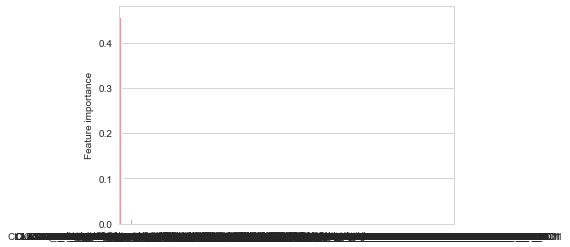

In [41]:
ax_gbm = sns.barplot(x=features_gbm.index, y=features_gbm.iloc[:,0], order=features_gbm.index)
ax_gbm.set_ylabel('Feature importance')
fig_gbm = ax_gbm.get_figure()

In [80]:
# Random Forest

rf = evaluate_model(629, X, RandomForestClassifier, 'RandomForest', 
                    {'n_estimators': [100, 200, 400, 800, 1000], 
                    'max_depth': [2, 3, 4, 5],
                    'min_samples_leaf': [2,3],
                    'min_samples_split': [2,3],
                    'max_features': ['auto', 'sqrt', 'log2']}, passes=250)

Pass 1/250 for model <class 'sklearn.ensemble._forest.RandomForestClassifier'>
Pass 2/250 for model <class 'sklearn.ensemble._forest.RandomForestClassifier'>
Pass 3/250 for model <class 'sklearn.ensemble._forest.RandomForestClassifier'>
Pass 4/250 for model <class 'sklearn.ensemble._forest.RandomForestClassifier'>
Pass 5/250 for model <class 'sklearn.ensemble._forest.RandomForestClassifier'>
Pass 6/250 for model <class 'sklearn.ensemble._forest.RandomForestClassifier'>
Pass 7/250 for model <class 'sklearn.ensemble._forest.RandomForestClassifier'>
Pass 8/250 for model <class 'sklearn.ensemble._forest.RandomForestClassifier'>
Pass 9/250 for model <class 'sklearn.ensemble._forest.RandomForestClassifier'>
Pass 10/250 for model <class 'sklearn.ensemble._forest.RandomForestClassifier'>
Pass 11/250 for model <class 'sklearn.ensemble._forest.RandomForestClassifier'>
Pass 12/250 for model <class 'sklearn.ensemble._forest.RandomForestClassifier'>
Pass 13/250 for model <class 'sklearn.ensemble._f

In [21]:
# CART: classification and regression tree

cart = evaluate_model(481, X, DecisionTreeClassifier, 'CART', 
                      {'splitter': ['best', 'random'], 
                      'criterion': ['gini', 'entropy'],
                      'max_depth': [2, 3, 4, 5],
                      'min_samples_leaf': [2,3],
                      'max_features' : ['auto', 'sqrt', 'log2']}, passes=250)

Pass 1/250 for model <class 'sklearn.tree._classes.DecisionTreeClassifier'>
Pass 2/250 for model <class 'sklearn.tree._classes.DecisionTreeClassifier'>
Pass 3/250 for model <class 'sklearn.tree._classes.DecisionTreeClassifier'>
Pass 4/250 for model <class 'sklearn.tree._classes.DecisionTreeClassifier'>
Pass 5/250 for model <class 'sklearn.tree._classes.DecisionTreeClassifier'>
Pass 6/250 for model <class 'sklearn.tree._classes.DecisionTreeClassifier'>
Pass 7/250 for model <class 'sklearn.tree._classes.DecisionTreeClassifier'>
Pass 8/250 for model <class 'sklearn.tree._classes.DecisionTreeClassifier'>
Pass 9/250 for model <class 'sklearn.tree._classes.DecisionTreeClassifier'>
Pass 10/250 for model <class 'sklearn.tree._classes.DecisionTreeClassifier'>
Pass 11/250 for model <class 'sklearn.tree._classes.DecisionTreeClassifier'>
Pass 12/250 for model <class 'sklearn.tree._classes.DecisionTreeClassifier'>
Pass 13/250 for model <class 'sklearn.tree._classes.DecisionTreeClassifier'>
Pass 14/

In [43]:
# Neural network: multi-layer perceptron

nnmlp = evaluate_model(597, X, MLPClassifier, 'NN', 
                       {'hidden_layer_sizes': [(50,)*3, (50,)*5, (50,)*10, (50,)*30, (50,)*50],
                        'activation': ['identity','logistic','tanh','relu']}, passes=250)

Pass 1/250 for model <class 'sklearn.neural_network._multilayer_perceptron.MLPClassifier'>
Pass 2/250 for model <class 'sklearn.neural_network._multilayer_perceptron.MLPClassifier'>
Pass 3/250 for model <class 'sklearn.neural_network._multilayer_perceptron.MLPClassifier'>
Pass 4/250 for model <class 'sklearn.neural_network._multilayer_perceptron.MLPClassifier'>
Pass 5/250 for model <class 'sklearn.neural_network._multilayer_perceptron.MLPClassifier'>
Pass 6/250 for model <class 'sklearn.neural_network._multilayer_perceptron.MLPClassifier'>
Pass 7/250 for model <class 'sklearn.neural_network._multilayer_perceptron.MLPClassifier'>
Pass 8/250 for model <class 'sklearn.neural_network._multilayer_perceptron.MLPClassifier'>
Pass 9/250 for model <class 'sklearn.neural_network._multilayer_perceptron.MLPClassifier'>
Pass 10/250 for model <class 'sklearn.neural_network._multilayer_perceptron.MLPClassifier'>
Pass 11/250 for model <class 'sklearn.neural_network._multilayer_perceptron.MLPClassifier

In [34]:
# Support Vector Machine: 

svm = evaluate_model(806, X, SVC, 'SVM', 
                    {'kernel': ['linear'], 
                     'probability': [True], 
                     'C': np.arange(0.1,3,0.1),
                     'max_iter': [1000, 2000, 4000]}, passes=250)

Pass 1/250 for model <class 'sklearn.svm._classes.SVC'>
[0.         0.         0.06060606 0.06060606 0.21212121 0.21212121
 0.45454545 0.45454545 0.51515152 0.51515152 0.57575758 0.57575758
 0.6969697  0.6969697  0.72727273 0.72727273 0.81818182 0.81818182
 0.87878788 0.87878788 0.90909091 0.90909091 0.96969697 0.96969697
 1.        ]
[0.         0.05555556 0.05555556 0.11111111 0.11111111 0.16666667
 0.16666667 0.27777778 0.27777778 0.33333333 0.33333333 0.38888889
 0.38888889 0.5        0.5        0.55555556 0.55555556 0.72222222
 0.72222222 0.77777778 0.77777778 0.83333333 0.83333333 1.
 1.        ]
Pass 2/250 for model <class 'sklearn.svm._classes.SVC'>
[0.         0.         0.06060606 0.06060606 0.12121212 0.12121212
 0.3030303  0.3030303  0.33333333 0.33333333 0.39393939 0.39393939
 0.63636364 0.63636364 0.6969697  0.6969697  0.75757576 0.75757576
 0.81818182 0.81818182 1.         1.        ]
[0.         0.05555556 0.05555556 0.16666667 0.16666667 0.22222222
 0.22222222 0.388888

In [3]:
from joblib import dump, load

In [4]:
#roc_plots = load('roc_plots_all.obj')

In [5]:
train = roc_plots['train']
test = roc_plots['test']
best = roc_plots['best']
best_roc = roc_plots['best_roc']
train.keys()

dict_keys(['Ridge', 'KNN', 'CART', 'SVM', 'GBC', 'Lasso', 'NN', 'RandomForest'])

In [6]:
for model3, data3 in best.items():
    print(model3)
    print(data3[0])
    print(data3[1])

Ridge
[0.         0.         0.         0.03030303 0.03030303 1.        ]
[0.         0.05555556 0.94444444 0.94444444 1.         1.        ]
KNN
[0.         0.         0.12121212 0.42424242 0.90909091 1.        ]
[0.         0.11111111 0.5        0.83333333 1.         1.        ]
CART
[0.         0.         0.36363636 0.60606061 1.        ]
[0.         0.5        0.83333333 1.         1.        ]
SVM
[0.         0.         0.03030303 0.03030303 0.06060606 0.06060606
 0.12121212 0.12121212 0.21212121 0.21212121 0.24242424 0.24242424
 0.27272727 0.27272727 0.39393939 0.39393939 0.54545455 0.54545455
 0.63636364 0.63636364 0.78787879 0.78787879 0.93939394 0.93939394
 1.         1.        ]
[0.         0.05555556 0.05555556 0.16666667 0.16666667 0.27777778
 0.27777778 0.38888889 0.38888889 0.5        0.5        0.61111111
 0.61111111 0.66666667 0.66666667 0.72222222 0.72222222 0.77777778
 0.77777778 0.83333333 0.83333333 0.88888889 0.88888889 0.94444444
 0.94444444 1.        ]
GBC
[0. 0. 

In [7]:
keyorder = ["GBC","RandomForest","CART","Lasso","Ridge","KNN","SVM","NN"]

train_sort =  {k:train[k] for k in keyorder}
print(train_sort.keys())

test_sort =  {k:test[k] for k in keyorder}
print(test_sort.keys())

best_sort = {k:best[k] for k in keyorder}
print(best_sort.keys())

bestroc_sort = {k:best_roc[k] for k in keyorder}
bestroc_sort

dict_keys(['GBC', 'RandomForest', 'CART', 'Lasso', 'Ridge', 'KNN', 'SVM', 'NN'])
dict_keys(['GBC', 'RandomForest', 'CART', 'Lasso', 'Ridge', 'KNN', 'SVM', 'NN'])
dict_keys(['GBC', 'RandomForest', 'CART', 'Lasso', 'Ridge', 'KNN', 'SVM', 'NN'])


{'GBC': 1.0,
 'RandomForest': 1.0,
 'CART': 0.8585858585858586,
 'Lasso': 0.9646464646464646,
 'Ridge': 0.9983164983164984,
 'KNN': 0.7744107744107744,
 'SVM': 0.6717171717171717,
 'NN': 0.7626262626262627}

In [8]:
best_sort

{'GBC': [array([0., 0., 0., 1.]),
  array([0.        , 0.05555556, 1.        , 1.        ])],
 'RandomForest': [array([0., 0., 0., 1.]),
  array([0.        , 0.05555556, 1.        , 1.        ])],
 'CART': [array([0.        , 0.        , 0.36363636, 0.60606061, 1.        ]),
  array([0.        , 0.5       , 0.83333333, 1.        , 1.        ])],
 'Lasso': [array([0.        , 0.        , 0.        , 0.03030303, 0.03030303,
         0.06060606, 0.06060606, 0.09090909, 0.09090909, 1.        ]),
  array([0.        , 0.05555556, 0.5       , 0.5       , 0.61111111,
         0.61111111, 0.72222222, 0.72222222, 1.        , 1.        ])],
 'Ridge': [array([0.        , 0.        , 0.        , 0.03030303, 0.03030303,
         1.        ]),
  array([0.        , 0.05555556, 0.94444444, 0.94444444, 1.        ,
         1.        ])],
 'KNN': [array([0.        , 0.        , 0.12121212, 0.42424242, 0.90909091,
         1.        ]),
  array([0.        , 0.11111111, 0.5       , 0.83333333, 1.        ,


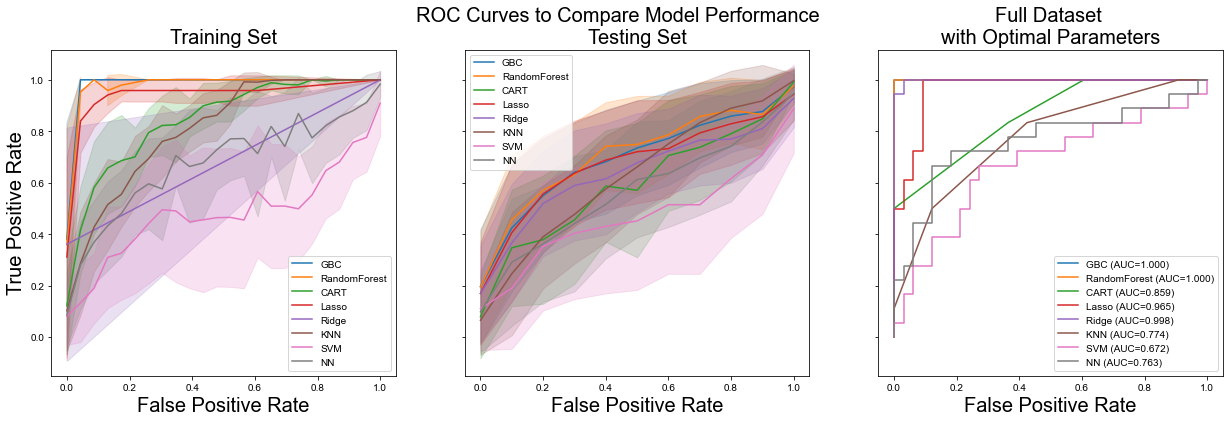

<Figure size 432x288 with 0 Axes>

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols = 3, sharey = True, figsize=(21, 6))

for model1, data1 in train_sort.items():
    x_tot = []
    y_tot = []
    for (fpr_tr, tpr_tr) in data1:
        x_tot.extend(fpr_tr)
        y_tot.extend(tpr_tr)
    sns.lineplot(x_tot, y_tot, ci="sd", ax=ax1)
    
ax1.set_xlabel('False Positive Rate', fontsize = 20)
ax1.set_ylabel('True Positive Rate', fontsize = 20)
ax1.set_title('Training Set', fontsize = 20)
ax1.legend(labels=train_sort.keys())

for model2, data2 in test_sort.items():
    x_tot = []
    y_tot = []
    for (fpr_ts, tpr_ts) in data2:
        x_tot.extend(fpr_ts)
        y_tot.extend(tpr_ts)
    sns.lineplot(x_tot, y_tot, ci="sd", ax=ax2)
    
ax2.set_xlabel('False Positive Rate', fontsize = 20)
ax2.set_title('Testing Set', fontsize = 20)
ax2.legend(labels=test_sort.keys())

plt.subplot(ax3)
for model3, data3 in best_sort.items():
    plt.plot(data3[0], data3[1])
    
ax3.set_xlabel('False Positive Rate', fontsize = 20)
ax3.set_title('Full Dataset \nwith Optimal Parameters', fontsize = 20)
finallabels = [f'{n} (AUC={bestroc_sort[n]:.3f})' for n in bestroc_sort.keys()]
ax3.legend(labels=finallabels)

fig.suptitle('ROC Curves to Compare Model Performance', fontsize = 20)
sns.set_style("whitegrid")
plt.show()
plt.clf()

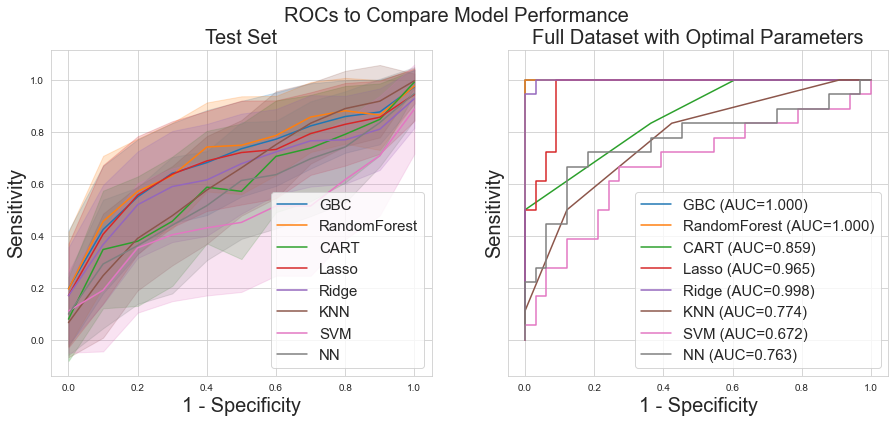

<Figure size 432x288 with 0 Axes>

In [13]:
fig, (ax2, ax3) = plt.subplots(nrows = 1, ncols = 2, sharey = True, figsize=(15, 6))

for model2, data2 in test_sort.items():
    x_tot = []
    y_tot = []
    for (fpr_ts, tpr_ts) in data2:
        x_tot.extend(fpr_ts)
        y_tot.extend(tpr_ts)
    sns.lineplot(x_tot, y_tot, ci="sd", ax=ax2)

ax2.set_ylabel('Sensitivity', fontsize = 20)
ax2.set_xlabel('1 - Specificity', fontsize = 20)
ax2.set_title('Test Set', fontsize = 20)
ax2.legend(labels=test_sort.keys(), fontsize = 15)

plt.subplot(ax3)
for model3, data3 in best_sort.items():
    plt.plot(data3[0], data3[1])

ax3.set_ylabel('Sensitivity', fontsize = 20)
ax3.set_xlabel('1 - Specificity', fontsize = 20)
ax3.set_title('Full Dataset with Optimal Parameters', fontsize = 20)
finallabels = [f'{n} (AUC={bestroc_sort[n]:.3f})' for n in bestroc_sort.keys()]
ax3.legend(labels=finallabels, fontsize = 15)

fig.suptitle('ROCs to Compare Model Performance', fontsize = 20)
sns.set_style("whitegrid")
plt.show()
plt.clf()

In [85]:
dump(roc_plots, 'roc_plots_all.obj')

['roc_plots_all.obj']

In [87]:
dump(rf, 'binary_rf.obj')

['binary_rf.obj']

In [88]:
dump(gbm, 'binary_gbm.obj')

['binary_gbm.obj']

In [24]:
data.to_excel(r'/mnt/ChelseaFolder/AnalysisData/COVIDdata_cj08272020.xlsx',index=None, header=True)